# LAB 2_ CLASSIFICATION

### Rubric

#### Data Preparation (15 points total)
- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Modeling and Evaluation (70 points total)
- Choose and explain your evaluation metrics that you will use (i.e., accuracy,precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
- Create three different classification/regression models for each task (e.g.,random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

### Deployment (5 points total)
- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work (10 points total)

- You have free reign to provide additional analyses.
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn as sns

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [2]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean_new.csv', low_memory= False)

#--------------------------------------------
# Police arrest records for crosss reference
#--------------------------------------------
police_arrest = pd.read_csv(path + 'Police_arrests.csv', low_memory=False)

In [3]:
Arrest_Inc = pd.DataFrame (police_arrest['IncidentNum'].dropna())

In [4]:
Arrest_Inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125426 entries, 0 to 125425
Data columns (total 1 columns):
IncidentNum    125426 non-null object
dtypes: object(1)
memory usage: 1.9+ MB


In [5]:
incident = pd.merge(incident,Arrest_Inc, how='left', left_on = 'Incident_Number_w/year', right_on = 'IncidentNum')

In [6]:
incident.info()
incident.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256278 entries, 0 to 256277
Data columns (total 48 columns):
Unnamed: 0                 256278 non-null int64
Incident_Number_w/year     256278 non-null object
Year_of_Incident           256278 non-null int64
Service_Number_ID          256278 non-null object
Watch                      256278 non-null int64
Type_of_Incident           256278 non-null object
Type_Location              251346 non-null object
Reporting_Area             256122 non-null float64
Beat                       256207 non-null float64
Division                   256278 non-null object
Sector                     256207 non-null float64
Council_District           256278 non-null object
Day1_of_the_Week           256278 non-null object
Call_Received_Date_Time    255213 non-null object
Call_Cleared_Date_Time     255045 non-null object
Call_Dispatch_Date_Time    255192 non-null object
Person_Involvement_Type    256278 non-null object
Victim_Type                256278 non-n

,Unnamed: 0,Incident_Number_w/year,Year_of_Incident,Service_Number_ID,Watch,Type_of_Incident,Type_Location,Reporting_Area,Beat,Division,...,Call_Received,Call_Cleared,Call_Dispatch,Number_of_offense,Response_time,Latitude,Longitude,Arrest_status,Call_Received_Hour,IncidentNum
0,2,175975-2016,2016,175975-2016-01,1,BMV,Motor Vehicle,3104.0,542.0,NORTHWEST,...,2016-07-22 03:43:21,2016-07-22 11:49:54,2016-07-22 03:52:33,01,9.0,32.823936,-96.82623,1,3.0,175975-2016
1,2,175975-2016,2016,175975-2016-01,1,BMV,Motor Vehicle,3104.0,542.0,NORTHWEST,...,2016-07-22 03:43:21,2016-07-22 11:49:54,2016-07-22 03:52:33,01,9.0,32.823936,-96.82623,1,3.0,175975-2016
2,5,258177-2015,2015,258177-2015-01,3,DEADLY CONDUCT,Apartment Parking Lot,4380.0,451.0,SOUTHWEST,...,2015-11-05 18:37:20,2015-11-05 19:32:15,2015-11-05 18:51:51,01,14.0,32.653927,-96.88384,0,18.0,NaN


In [7]:
#-----------------------------------------------------------------    
# Arrest_status variable binary coding
#-----------------------------------------------------------------
def get_status(row):
    if row['Offense_Status']=='Clear by Arrest':
        return 1
    elif row['Offense_Status']=='Clear by Exceptional Arrest':
        return 1
    elif not pd.isnull(row['IncidentNum']):
        return 1
    else:
        return 0

#------------------------------------------------------------
# Incident arrest status based on "Offense_Status" attribute
#------------------------------------------------------------
incident.loc[:,'Arrest_status']= incident.apply(get_status, axis=1) 

In [8]:
incident['Arrest_status'].value_counts()

0    229639
1     26639
Name: Arrest_status, dtype: int64

In [9]:

# Exploying the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
# print(incident.shape)
# print('Number of null columns and their counts')
# print(incident_NullCols)

In [10]:

# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]
incident =  incident[incident['X_Coordinate']>0]
incident =  incident[incident['Y_Coordinate']>0]

In [11]:

# Further data clean up on the feature variables

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [13]:

# Change norminal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)
# coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes
incident['Person_Involvement_Type'] = pd.Categorical(incident['Person_Involvement_Type']).codes
incident['UCR_Offense_Description'] = pd.Categorical(incident['UCR_Offense_Description']).codes

In [14]:
# incident.describe()

In [15]:
incident = incident.drop(['Year_of_Incident',
                          #'Service_Number_ID', 
                          'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District',
                          'Call_Received_Date_Time', 'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time',
                          #'Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition',
                          #'Family_Offense', 
                          'Weapon_Used', 
                          'RMS_Code', 'UCR_Code',
                          #'X_Coordinate', 'Y_Coordinate',
                          #'Zip_Code', 
                          'City', 'State',
                          'Location1', 
                          'Call_Received', 'Call_Cleared', 'Call_Dispatch',
                          'Latitude', 'Longitude','Unnamed: 0'],axis=1)

Class 0: 184733
Class 1: 23258
Proportion: 7.94 : 1


<Figure size 576x360 with 0 Axes>

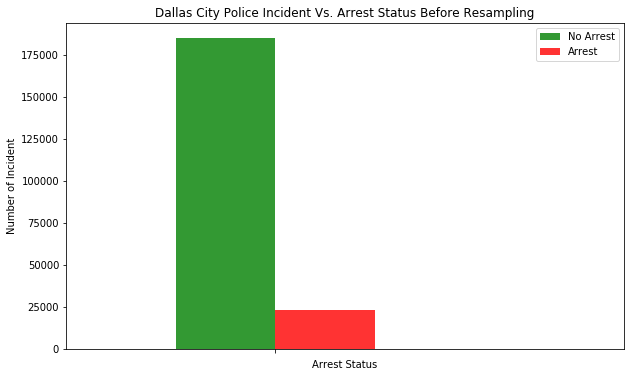

In [16]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [17]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=23258,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    23258
0    23258
Name: Arrest_status, dtype: int64

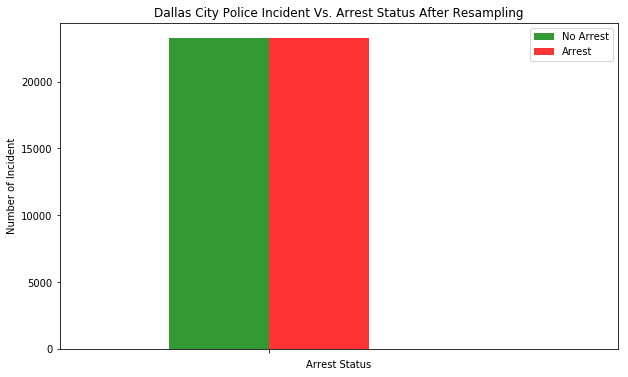

In [18]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

In [19]:
# copy the down sampling dataset to original incident data frame and continue the anl
incident= df_downsampled.copy() # skip reampling for now

In [20]:

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Drug_Related          Social_crime_score         0.842025
Call_Received_Hour    Watch                      0.714936
UCR_Offense_Name      UCR_Offense_Description    0.682055
Gang_Related_Offense  Social_crime_score         0.572519
Y_Coordinate          Victim_Race                0.254865
                                                   ...   
Response_time         Arrest_status             -0.182065
Arrest_status         UCR_Offense_Description   -0.226914
Victim_Race           Division                  -0.287539
Arrest_status         UCR_Offense_Name          -0.289751
Division              Y_Coordinate              -0.619457
Length: 210, dtype: float64


In [21]:
#Drop highly correlated, insignificant and high VIF columns.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

UCR_Offense_Name         UCR_Offense_Description    0.682055
Y_Coordinate             Victim_Race                0.254865
UCR_Offense_Name         Victim_Race                0.127743
UCR_Offense_Description  Victim_Race                0.110224
Number_of_offense        Social_crime_score         0.106100
                                                      ...   
Response_time            Arrest_status             -0.182065
Arrest_status            UCR_Offense_Description   -0.226914
Division                 Victim_Race               -0.287539
Arrest_status            UCR_Offense_Name          -0.289751
Y_Coordinate             Division                  -0.619457
Length: 136, dtype: float64


In [22]:
#-----------------------------------------------------------------------------
# Aggregating the data
#-----------------------------------------------------------------------------
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

#-----------------------------------------------------------------------------
# Renaming the headers for clarity
#-----------------------------------------------------------------------------
incident_NullCols = pd.DataFrame({'n Missing' : incident_NullCols,
                                  '% Missing' : ((incident_NullCols / incident.shape[0])*100).round(2)})

#-----------------------------------------------------------------------------
# Sorting the dataframe 
#-----------------------------------------------------------------------------
incident_NullCols = incident_NullCols.sort_values('n Missing')

#-----------------------------------------------------------------------------
# Color coding the results for enhanced visualization of results
#-----------------------------------------------------------------------------
cm = sns.light_palette("red", as_cmap=True)
incident_NullCols.style.background_gradient(cmap=cm)


,n Missing,% Missing
Family_Offense,13,0.03
IncidentNum,37954,81.59


In [23]:
incident = incident.drop(['Family_Offense',
                          #'Call_Dispatch_Date_Time','Call_Cleared_Date_Time','Call_Received_Date_Time',
                          #'UCR_Offense_Description',
                          'IncidentNum','Incident_Number_w/year',
                          'Service_Number_ID'
                        #,'Unnamed: 0'
                         ]
                         ,axis = 1)

In [24]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46516 entries, 231052 to 256267
Data columns (total 17 columns):
Division                   46516 non-null int8
Day1_of_the_Week           46516 non-null int8
Person_Involvement_Type    46516 non-null int8
Victim_Type                46516 non-null int8
Victim_Race                46516 non-null int8
Victim_Age                 46516 non-null int32
UCR_Offense_Name           46516 non-null int8
X_Coordinate               46516 non-null float64
Y_Coordinate               46516 non-null float64
Zip_Code                   46516 non-null int64
UCR_Offense_Description    46516 non-null int8
Number_of_offense          46516 non-null int32
Response_time              46516 non-null int32
Arrest_status              46516 non-null int64
Call_Received_Hour         46516 non-null float64
IsMale                     46516 non-null int32
Social_crime_score         46516 non-null int64
dtypes: float64(3), int32(4), int64(3), int8(7)
memory usage: 3.5 MB


In [25]:
incident_final = incident.copy()

In [26]:

# Y Response variable dataframe
inci_Y = incident_final['Arrest_status']

# Features with no predictive features with respect to resposne variable
inci_X = incident_final.drop(['Arrest_status'],axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X = scaler.fit_transform(inci_X)
# inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
# inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
inci_X = pd.DataFrame(inci_X)
# df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
# df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

### Cross Validation 

In [28]:
inci_X.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [29]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [30]:
%%time
inci_X = inci_X.as_matrix().astype(np.float)
inci_Y = inci_Y.as_matrix().astype(np.float)

for trainidx, testidx in cv.split(inci_X,inci_Y):
    X_train, X_test = inci_X[trainidx], inci_X[testidx]    
    y_train, y_test = inci_Y[trainidx], inci_Y[testidx]

Wall time: 96.8 ms


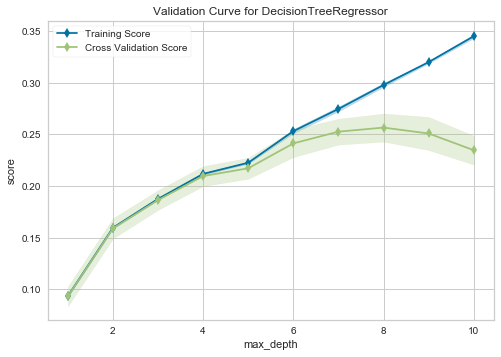

In [31]:

from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import ValidationCurve


viz = ValidationCurve(
    DecisionTreeRegressor(),  param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [32]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
acc_score = []
pres_score = []

# Will take some time
for K in np.arange(1, 40, 1):
    print("Iteration:: ",K)
    knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    knn.fit(X_train,y_train)
    yhat = knn.predict(X_test)
    
    error_rate.append(np.mean(yhat != y_test))
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    acc_score.append(acc)
    pres_score.append(pres)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
    print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Iteration::  1
Classification Report
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62      4619
         1.0       0.62      0.63      0.63      4685

   micro avg       0.62      0.62      0.62      9304
   macro avg       0.62      0.62      0.62      9304
weighted avg       0.62      0.62      0.62      9304

Confusion Matrix
[[2845 1774]
 [1737 2948]]
Accuracy of classifier with 1 neighbors is: 0.62
Precision Score of classifier with 1 neighbors is: 0.62
Iteration::  2
Classification Report
              precision    recall  f1-score   support

         0.0       0.58      0.80      0.67      4619
         1.0       0.68      0.42      0.52      4685

   micro avg       0.61      0.61      0.61      9304
   macro avg       0.63      0.61      0.59      9304
weighted avg       0.63      0.61      0.59      9304

Confusion Matrix
[[3687  932]
 [2723 1962]]
Accuracy of classifier with 2 neighbors is: 0.61
Precision Score of classifier 

Classification Report
              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66      4619
         1.0       0.67      0.67      0.67      4685

   micro avg       0.67      0.67      0.67      9304
   macro avg       0.67      0.67      0.67      9304
weighted avg       0.67      0.67      0.67      9304

Confusion Matrix
[[3062 1557]
 [1538 3147]]
Accuracy of classifier with 17 neighbors is: 0.67
Precision Score of classifier with 17 neighbors is: 0.67
Iteration::  18
Classification Report
              precision    recall  f1-score   support

         0.0       0.65      0.70      0.67      4619
         1.0       0.68      0.64      0.66      4685

   micro avg       0.67      0.67      0.67      9304
   macro avg       0.67      0.67      0.67      9304
weighted avg       0.67      0.67      0.67      9304

Confusion Matrix
[[3222 1397]
 [1707 2978]]
Accuracy of classifier with 18 neighbors is: 0.67
Precision Score of classifier with 18 nei

Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      4619
         1.0       0.68      0.66      0.67      4685

   micro avg       0.67      0.67      0.67      9304
   macro avg       0.67      0.67      0.67      9304
weighted avg       0.67      0.67      0.67      9304

Confusion Matrix
[[3144 1475]
 [1586 3099]]
Accuracy of classifier with 33 neighbors is: 0.67
Precision Score of classifier with 33 neighbors is: 0.68
Iteration::  34
Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68      4619
         1.0       0.69      0.64      0.66      4685

   micro avg       0.67      0.67      0.67      9304
   macro avg       0.67      0.67      0.67      9304
weighted avg       0.67      0.67      0.67      9304

Confusion Matrix
[[3242 1377]
 [1673 3012]]
Accuracy of classifier with 34 neighbors is: 0.67
Precision Score of classifier with 34 nei

Wall time: 14 ms


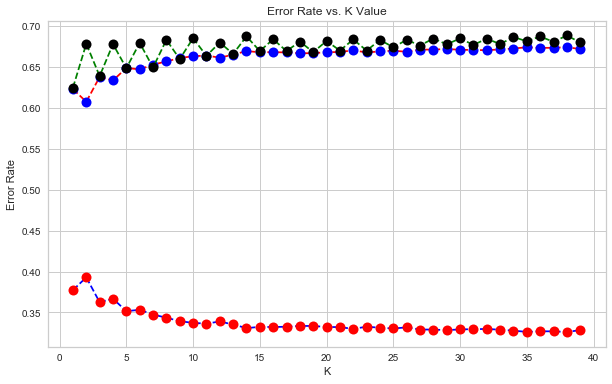

In [33]:
%%time

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 40, 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.plot(np.arange(1, 40, 1),acc_score,color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.plot(np.arange(1, 40, 1),pres_score,color='green', linestyle='dashed', marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [35]:
%%time

K=14 #39

knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
knn.fit(X_train,y_train)
yhat = knn.predict(X_test)

acc = accuracy_score(y_test, yhat)
pres = precision_score(y_test, yhat)
print('Classification Report')
print(classification_report(y_test, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))
print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Classification Report
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68      4619
         1.0       0.69      0.63      0.66      4685

   micro avg       0.67      0.67      0.67      9304
   macro avg       0.67      0.67      0.67      9304
weighted avg       0.67      0.67      0.67      9304

Confusion Matrix
[[3275 1344]
 [1735 2950]]
Accuracy of classifier with 14 neighbors is: 0.67
Precision Score of classifier with 14 neighbors is: 0.69
Wall time: 15.6 s


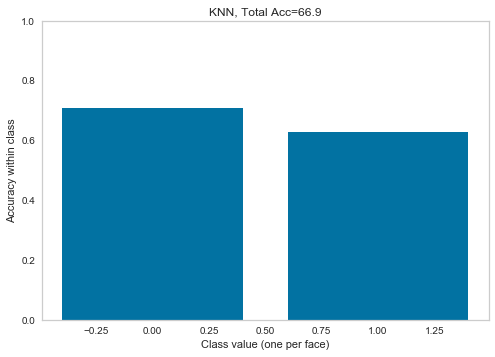

In [36]:
from sklearn import metrics as mt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y_test,yhat,title="KNN")

In [37]:
%%time

from sklearn.neighbors.nearest_centroid import NearestCentroid
for d in ['l1', 'l2', 'cosine', 'euclidean']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
    print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

Classification Report
              precision    recall  f1-score   support

         0.0       0.63      0.71      0.67      4619
         1.0       0.67      0.59      0.63      4685

   micro avg       0.65      0.65      0.65      9304
   macro avg       0.65      0.65      0.65      9304
weighted avg       0.65      0.65      0.65      9304

Confusion Matrix
[[3269 1350]
 [1904 2781]]
Accuracy of classifier with l1 metric is: 0.65
Precision Score of classifier with l1 metric is: 0.67
Classification Report
              precision    recall  f1-score   support

         0.0       0.64      0.67      0.65      4619
         1.0       0.66      0.64      0.65      4685

   micro avg       0.65      0.65      0.65      9304
   macro avg       0.65      0.65      0.65      9304
weighted avg       0.65      0.65      0.65      9304

Confusion Matrix
[[3076 1543]
 [1709 2976]]
Accuracy of classifier with l2 metric is: 0.65
Precision Score of classifier with l2 metric is: 0.66
Classificati

Accuracy 0.7489251934651763


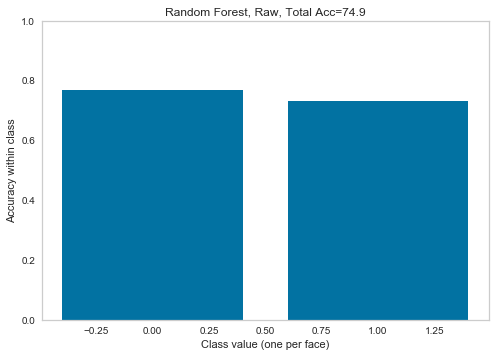

Wall time: 3.2 s


In [38]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(inci_X,inci_Y):
    X_train, X_test = inci_X[train], inci_X[test]    
    y_train, y_test = inci_Y[train], inci_Y[test]
    
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y_test,yhat,title="Random Forest, Raw")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


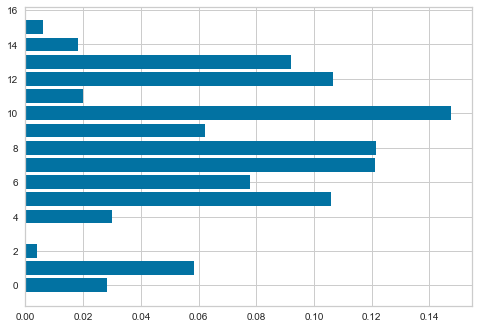

Generalization score estimate from training data 0.7434698484359884


In [39]:
# now lets get access to the different properties of our RF

print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation

- Overall importance of each feature, magnitude of feature importance.

# TREE ENSEMBLE METHOD

In [40]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],inci_X,inci_Y)
    print (clf[0], acc.mean())

Stump 0.6353726728550676
Tree 0.6420796985229948
Random Trees 0.7247606411641936
Extra Random Trees 0.7197947077844762
Boosted Tree 0.7249759389387802
Wall time: 17.7 s


Pipeline accuracy 0.538585554600172


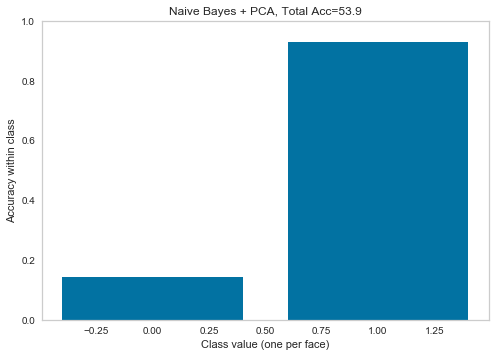

In [41]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=11,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(inci_X,inci_Y):
    X_train, X_test = inci_X[train], inci_X[test]    
    y_train, y_test = inci_Y[train], inci_Y[test]

clf_pipe.fit(X_train,y_train)
yhat = clf_pipe.predict(X_test)

total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y_test,yhat,title="Naive Bayes + PCA")

In [42]:
from sklearn import metrics as mt

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y_test, yhat)
per_class_acc_list = per_class_accuracy(y_test,yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y_test):
    idx = (y_test==cls) # get classes
    ytmp_actual = np.zeros(y_test.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y_test.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print ('Total Accuracy:',total_accuracy)
print ('Number of infrequent faces:',len(recall_for_infreq_classes), 
       'with average recall of:', np.mean(recall_for_infreq_classes))
print ('Number of frequent faces:',len(prec_for_freq_classes), 
       'with average precision of:',np.mean(prec_for_freq_classes))

Total Accuracy: 0.538585554600172
Number of infrequent faces: 0 with average recall of: nan
Number of frequent faces: 2 with average precision of: 0.5931417098349675


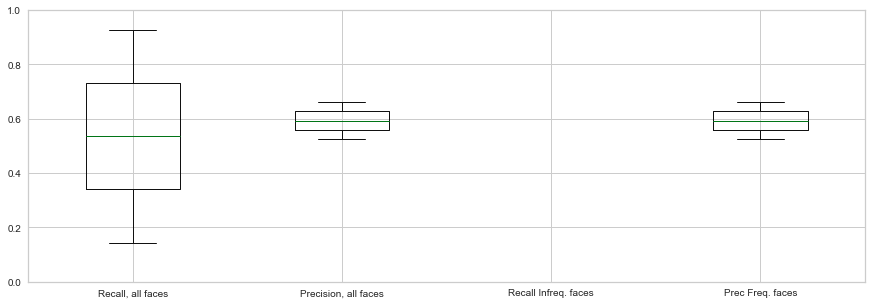

In [43]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ rec_tot, prec_tot, recall_for_infreq_classes,prec_for_freq_classes],
            labels=['Recall, all faces','Precision, all faces','Recall Infreq. faces','Prec Freq. faces'])
plt.ylim([0,1])
plt.show()

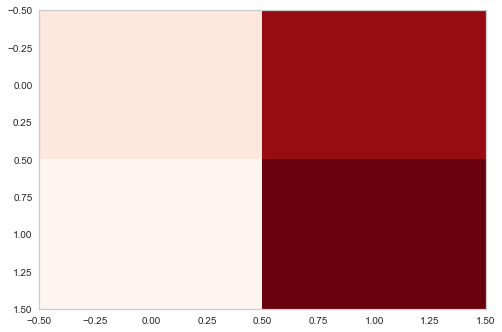

In [44]:
# how about plotting a confusion matrix?
cm = mt.confusion_matrix(y_test, yhat)
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

In [45]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# # Create classification dataset
# inci_X, inci_Y = make_classification(
#     n_samples=1000, n_classes=2, n_informative=3, n_clusters_per_class=1
# )

classes = ["No Arrest", "Arrest"]

# # Perform 80/20 training/test split
# X_train, X_test, y_train, y_test = train_test_split(inci_X, inci_Y, test_size=0.20,
#                                                     random_state=42)


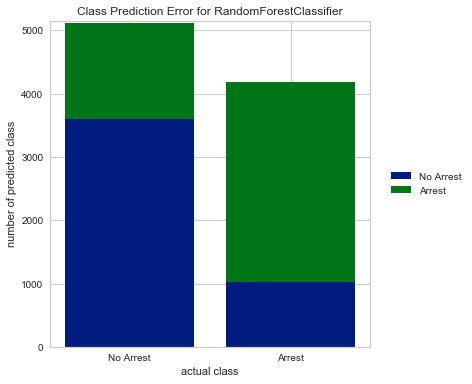

In [46]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    RandomForestClassifier(), classes=classes
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

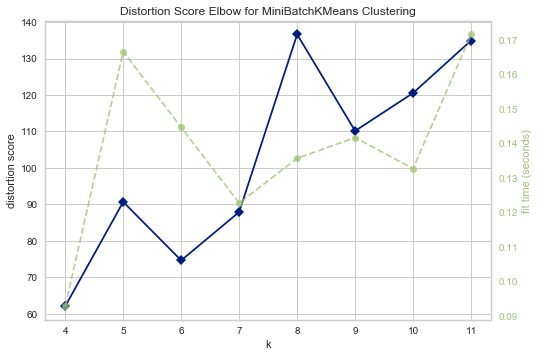

In [47]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(4,12))

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

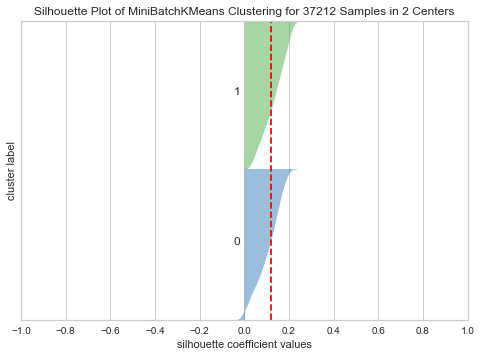

In [50]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(2)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### Decision Tree

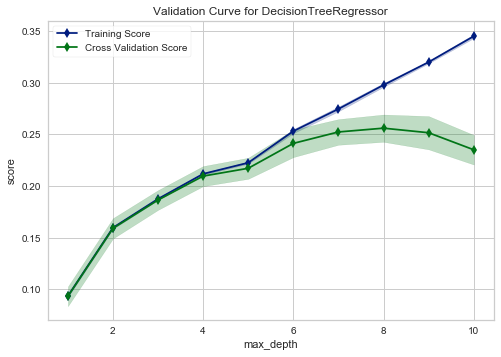

In [49]:
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [53]:
from sklearn import tree

clf_DTree = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2
                            , min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None
                            , random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0
                            , min_impurity_split=None, class_weight=None, presort=False)
clf_DTree = clf_DTree.fit(X_train, y_train)

yhat = clf_DTree.predict(X_test)
acc = accuracy_score(y_test, yhat)
pres = precision_score(y_test, yhat)
print('Classification Report')
print(classification_report(y_test, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))
print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.65      0.66      4619
         1.0       0.66      0.67      0.67      4685

   micro avg       0.66      0.66      0.66      9304
   macro avg       0.66      0.66      0.66      9304
weighted avg       0.66      0.66      0.66      9304

Confusion Matrix
[[3016 1603]
 [1524 3161]]
Accuracy of classifier with euclidean metric is: 0.66
Precision Score of classifier with euclidean metric is: 0.66


### SVM

In [ ]:
%%time

from sklearn.svm import SVC
param_range = np.logspace(-6, -1, 12)
viz = ValidationCurve(
    SVC(), param_name="gamma", param_range=param_range,
    logx=True, cv=cv, scoring="f1_weighted", n_jobs=8,
)

viz.fit(X_train, y_train)
viz.poof()

In [ ]:
%%time

#SVM model on main dataframe.
from sklearn.svc import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt


#train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(inci_X, inci_Y)  # train object

y_hat = svm_clf.predict(X_test)

acc = mt.accuracy_score(inci_Y,y_hat)
conf = mt.confusion_matrix(inci_Y,y_hat)
prec = mt.precision_score(inci_Y, y_hat)
recall = mt.recall_score(inci_Y, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})